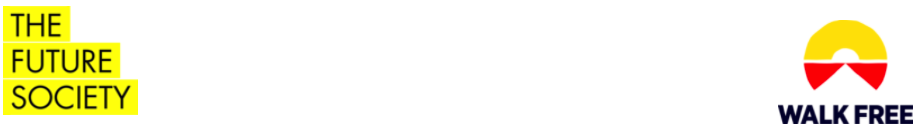

#*Project AIMS (AI against Modern Slavery)*
---




 
##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://colab.research.google.com/drive/16bIPfuuYVUNLRRVbbEht7Cw9duJoJsDW).

# Whistleblowing mechanism
 
## Does the company have a grievance mechanism in place to facilitate whistleblowing or the reporting of suspected incidents of slavery or trafficking?
The goal of this task is to check if the companies provide a hotline or reporting mechanism where grievances or suspected incidents of slavery or trafficking can be reported for direct employees and/or supply chains workers (positive case) or not (negative case). A whistleblowing mechanism may include a  reporting line or hotline that workers can call, whistleblower protections for employees so they will not be penalised if they report modern slavery cases or an employee or independent focal point to whom reports can be made. For many companies, the risk of forced labour is much greater within their supply chain than in their operations - as such, providing a mechanism that extends to workers within the company’s supply chain is regarded as a positive step. A whistleblowing mechanism may include:
- An anonymous reporting line or hotline that workers can call
- Whistleblower protections for employees and their families so they will not be penalised if they report modern slavery cases
- An employee or independent focal point to whom reports can be made
- A direct employee is someone who is working directly for the company either in the company head office or in regional offices.
- A supply chain worker is someone who is employed by contractors or subcontractors further down the supply chain.
 
For more information about this metric, please refer to  [WikiRate’s Research on MSA whistleblowing mechanism (revised) metric ](https://wikirate.org/Walk_Free_Foundation+MSA_whistleblowing_mechanism_revised), [ the Home Office Guidance, pp. 33](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf) or [CORE Guidance, pp. 19 ](http://corporate-responsibility.org/wp-content/uploads/2016/03/CSO_TISC_guidance_final_digitalversion_16.03.16.pdf).

 
 
## Labelled dataset
When building the labelled dataset,  if any of the above-mentioned mechanism was found, the annotations could label the statement with one or many of the following options:
- Hotline, Email, Contact Form (direct employees)
- Hotline, Email, Contact Form (supply chain workers)
- Whistleblower protection (direct employees)
- Whistleblower protection (supply chain workers)
- Focal Point (direct employees)
- Focal Point (supply chain workers)
 
If there is no mention in the statement of who the mechanism applies to, the annotators assumed it applies only to direct employees. If any of those labels were associated with the statement, the statement received, for the purpose of this task, the generic label ‘Yes/1’. Also, for each value, they included a Comment that copies relevant information from the statement.
If the business indicates it is developing a whistleblowing or grievance mechanism or planning to implement one in the future, the annotators selected ‘In Development’ and gave details in the Comments section. They select ‘No’ as a label if no whistleblowing mechanism is described in the statement. If a statement was labelled with any of those two labels, it received the label ‘No/0’ for this task.
 
 



In [ ]:
#!pip install snorkel
#!pip install -U sentence-transformers
#!python -m spacy download en

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

#os.chdir('/content/drive/My Drive/Project AIMS')

In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


## Setup

In [ ]:
import torch
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
import spacy
from spacy.tokens import Token
import en_core_web_sm
import re
import sys
from utils import sentencizer, evaluation_rb
from sentence_transformers import SentenceTransformer, util
import nltk
import nltk.data
nltk.download('punkt')
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
nlp = en_core_web_sm.load()

## Preprocessing

### 🗄️ You can access the data used in this notebook [here ](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).


In [ ]:
metric = 'Walk Free Foundation+MSA whistleblowing mechanism (revised)'
metric_binary = metric +' binary'

labeled_dataset = pd.read_csv("labeled-dataset.csv", dtype=object,  index_col=0)
print('Number of available statements for {} -> {:,}\n'.format(metric, labeled_dataset.shape[0]))

def textPreprocess(txt):
  txt = txt.replace('.\n\n','. ')
  txt = txt.replace('\n\n','. ')
  txt = txt.replace('.\n','. ')
  txt = txt.replace("\n",". ")
  return txt

Number of available statements for Walk Free Foundation+MSA whistleblowing mechanism (revised) -> 2,749



In [ ]:
labeled_dataset = labeled_dataset[~labeled_dataset[metric].isnull()]

In [ ]:
labeled_dataset = labeled_dataset[labeled_dataset[metric]!= 'Unknown']
labeled_dataset[metric].value_counts()

No                                                                                               596
Whistleblower protection (direct employees)                                                      241
Whistleblower protection (direct employees), Whistleblower protection (supply chain workers)     111
Hotline (direct employees)                                                                       106
Hotline (direct employees), Hotline (supply chain workers)                                        76
                                                                                                ... 
Hotline (supply chain workers), In Development (supply chain workers)                              1
Hotline (direct employees), Hotline (supply chain workers), In Development (direct employees)      1
Hotline (direct employees), Whistleblower protection (supply chain workers)                        1
Whistleblower protection (supply chain workers), In Development (supply chain workers)     

In [ ]:
labeled_dataset[metric] = [0 if str(value) == 'No' or str(value) == 'In Development' else 1 for value in labeled_dataset[metric]]
labeled_dataset[metric].value_counts()

1    962
0    596
Name: Walk Free Foundation+MSA whistleblowing mechanism (revised), dtype: int64

### Regular expression labeling function

In [ ]:
context_kw = [r'(modern|contemporary)([\s\S]{0,400})(slavery|enslavement|servitude|subjugation|trafficking|forced\s*(labor|labour)|child\s*(labor|labour))']

#An anonymous reporting line or hotline that workers can call ( reporting managed by third parties fall in this category too
hotline_kw = [r'hotline','helpline','opentalk','(report\w*|phone)([\S\s]{0,100})line','secure line','ethics line','24 hours','24/7',
              'website','anonymous reporting','confidential','mechanism for reporting','whistle-blow','whistleblow','whistleblower',
              'whistle','grievance\s*mechanism','grievance','mechanism([\S\s]\w*[\S\s]){1,4}reporting']

hotline_act_kw = ['report[\s\S]{0,300}((modern\s*slavery)|(any suspic)|(grievance|concerns|incidents|trafficking|ethical\s*violation|violation|non-compliance|forced\s*labor|rights))',
             'raise concerns','workers can call','suspected incidents','identify and report','Speak Up','appropriate steps to','report([\S\s]\w*[\S\s]){1,4}to']


#for employees and their families so they will not be penalised if they report modern slavery cases
protection_kw = ['anonymous','protect','retaliation','fear of','non-retaliation','secure[\S\s]{0,10}line','ethics[\S\s]{0,10}line',
                 'confidential','anonymous','(not|no)[\S\s]{0,100}(dismissal|disciplinary action|threats|unfavourable treatment)']

focalpoint_kw =['focal([\S\s]\w*[\S\s]){0,10}point','Email','contact supervisor','report[\S\s]{0,100}to']


context_regex_exp = re.compile( '|'.join( context_kw))
hotline_regex_exp = re.compile( '|'.join( hotline_kw))
hotline_act_regex_exp = re.compile( '|'.join( hotline_act_kw))
protection_regex_exp = re.compile( '|'.join( protection_kw))
focalpoint_regex_exp = re.compile( '|'.join( focalpoint_kw))


synonyms_modern = ['modern', 'contemporary']
synonyms_slavery = ['slavery', 'enslavement', 'servitude', 'subjugation', 'trafficking', 'forced labor', "forced labour", "child labor", "child labour"]


hotline_kw = ['hotline','suspected|incidents','secure line','ethics line','reporting|line','phone|line','anonymous|reporting',
              'confidential','whistleblow','whistle','helpline','whistle-blow',
              'report|modern|slavery', 'mechanism for reporting','mechanism|to','grievance','grievance|mechanism','channel',
              '24 hours','24/7','website','phone number','report|concerns','raise|concerns','workers|can|call','speak up',
              'suspected incidents','report|any|suspic', 'identify|and|report','report|trafficking','appropriate|steps|to',
              'report|ethical|violation','report|violation','report|non-compliance','report|forced|labor','report|rights','report|to']


protection_kw =['anonymous','protect','retaliation','fear of','non-retaliation','secure line','ethics line','confidential',
                'not|dismissal','not|disciplinary action','not|threats','not|unfavourable treatment']
focalpoint_kw =['focal point,','Email','contact supervisor','report|to'] #,'appropriate steps to','we encourage'

#create context kw combination of synonms of modern slavery
for modern in synonyms_modern:
    for slavery in synonyms_slavery:
        modern_slavery = modern + " " + slavery
        context_kw.append(modern_slavery)


#sentence segmentation
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
threshold = 0.6

# whistleblow_marks embedding
whistleblow_marks = ['Whistleblowing','report slavery cases','anonymous hotline','no retaliation',
    'mechanism for reporting','grievance mechanism','trafficking','ethical violation','forced labor','report unethical case',
    'workers can call','report concerns','raise concerns','report any suspic','identify and report',
    'appropriate steps to','secure line','ethics line ','confidential','report violation',
    'secure Ethics Open Line','operated by an independent third-party and is available 24 hours a day']
embeddings2 = model.encode(whistleblow_marks, convert_to_tensor=True)

In [ ]:
YES = 1
NO = 0
ABSTAIN = -1

@labeling_function()
def lf_whistleblow_ex_search(x):
    """
    :param x: string representation of a document
    :return: binary label
    """

    text = str(x.TEXT).strip().lower()
    if re.search(context_regex_exp, text)!= None:
        if (re.search(hotline_regex_exp, text)!= None)\
        or (re.search(hotline_act_regex_exp, text)!= None)\
        or (re.search(protection_regex_exp, text)!= None)\
        or (re.search(focalpoint_regex_exp, text)!= None):
            return YES
        else:
            return NO
    else:
        return NO

    
@labeling_function()
def lf_whistleblow_keyword_search(x):
    """
    :param x: string representation of a document
    :return: binary label
    """

    text = str(x.TEXT).strip().lower()
    text =textPreprocess(text)
    doc = nlp(text)
    list_sentences = [sent.text for sent in doc.sents]

    for sentence in list_sentences: 
        in_context = False
        for context in context_kw:
            if context in sentence:
                in_context =True
                break
        if in_context:
            #hotline
            for kw in hotline_kw:
                terms = kw.split("|")
                unfind = False
                for tem in terms:
                    if tem not in sentence:
                        unfind =True
                        break
                if not unfind:
                    return YES
            #whistleblower protection
            for kw in protection_kw:
                terms = kw.split("|")
                unfind = False
                for tem in terms:
                    if tem not in sentence:
                        unfind =True
                        break
                if not unfind:
                    return YES
            #focal point
            for kw in focalpoint_kw:
                terms = kw.split("|")
                unfind = False
                for tem in terms:
                    if tem not in sentence:
                        unfind =True
                        break
                if not unfind:
                    return YES 
    return NO



@labeling_function()
def lf_whistleblow_cosinsimilarity_search(x):
    """
    :param x: string representation of a document
    :return: binary label
    """
    if str(x.TEXT).strip().lower() =='nan' or str(x.TEXT).strip() == '' :
        return ABSTAIN
    else :
        text = textPreprocess(str(x.TEXT).strip())
        doc = nlp(text)
        list_sentences = [sent.text for sent in doc.sents]

        embeddings1 = model.encode(list_sentences, convert_to_tensor=True)
        
        cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
        if cosine_scores[cosine_scores>threshold].size()[0]>0 :

            return YES

        return NO


lfs = [lf_whistleblow_ex_search, lf_whistleblow_keyword_search, lf_whistleblow_cosinsimilarity_search]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df = labeled_dataset)

100%|██████████| 1558/1558 [1:46:23<00:00,  4.10s/it]


In [ ]:
coverage = (L_train != NO).mean(axis=0)
print("Whistleblower mechanism coverage is", coverage)

Whistleblower mechanism coverage is [0.70667522 0.26123235 0.79268293]


### 2.4  Generate the training dataset

In [ ]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)
L_train = applier.apply(labeled_dataset)

# Train the label model and compute the training labels
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
labeled_dataset["label"] = label_model.predict(L=L_train, tie_break_policy="abstain")

100%|██████████| 1558/1558 [1:46:20<00:00,  4.10s/it]


In [ ]:
labeled_dataset["Predicted label"] = label_model.predict(L=L_train, tie_break_policy="abstain")

In [ ]:
labeled_dataset.to_csv("whistleblower-training.csv")

## Results


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labeled_dataset[metric], labeled_dataset["Predicted label"]))

              precision    recall  f1-score   support

           0       0.54      0.41      0.47       596
           1       0.68      0.78      0.73       962

    accuracy                           0.64      1558
   macro avg       0.61      0.60      0.60      1558
weighted avg       0.63      0.64      0.63      1558



Evaluation of the rule-based model


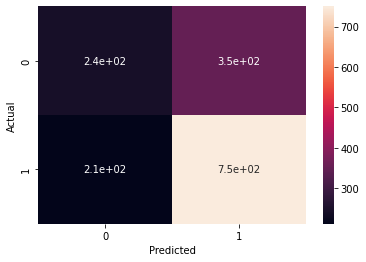

Confusion Matrix:
 [[245 351]
 [212 750]]
Accuracy Score: 0.6386392811296534
Precision Score: 0.6256944486912714
Recall Score: 0.6386392811296534
F1 Score: 0.6269625973058561


In [ ]:
evaluation_rb.main(labeled_dataset[metric], labeled_dataset["Predicted label"])

## Adding labels and matchsentence to the dataset

In [ ]:
# import nltk
# import nltk.data
# nltk.download('punkt')
#sentence segmentation
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')


def addRexLabelMatchSentence2Dataset(msd_df, label):
    #copy of the dataset
    msd_df_copy= msd_df.copy()

    msd_df_copy["Whistleblow_Predicted_label"] = label.reshape(-1) 
    msd_df_copy = msd_df_copy.reset_index(drop=True)
    msd_df_copy["Whistleblow_Found_element"] =''
    msd_df_copy["Whistleblow_Sentence"] =''
    for idx in msd_df_copy.index: 
        text = str(msd_df_copy.at[idx,'TEXT'])
        if L_train[idx][0] == 1:
            list_sentences = sent_detector.tokenize(text.strip().lower())

            whistleblow_found_element = ''
            whistleblow_sentence = ''
            for i,s in enumerate(list_sentences):
                if re.search(context_regex_exp, s):

                    if re.search(hotline_regex_exp, s):
                        match_obj = re.search(hotline_regex_exp, s)
                        whistleblow_found_element = match_obj.group(0)
                        whistleblow_sentence= s
                        break
                    if re.search(hotline_act_regex_exp, s):
                        match_obj = re.search(hotline_act_regex_exp, s)
                        whistleblow_found_element = match_obj.group(0)
                        whistleblow_sentence= s
                        break
                    if re.search(protection_regex_exp, s):
                        match_obj = re.search(protection_regex_exp, s)
                        whistleblow_found_element = match_obj.group(0)
                        whistleblow_sentence= s
                        break
                    if re.search(focalpoint_regex_exp, s):
                        match_obj = re.search(focalpoint_regex_exp, s)
                        whistleblow_found_element = match_obj.group(0)
                        whistleblow_sentence= s
                        break
            msd_df_copy.at[idx,'Whistleblow_Found_element'] =whistleblow_found_element
            msd_df_copy.at[idx,'Whistleblow_Sentence']=whistleblow_sentence
        else:

            msd_df_copy.at[idx,'Whistleblow_Sentence'] =str(text[-200:])
    return msd_df_copy

lfs = [lf_whistleblow_ex_search]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df=labeled_dataset)

result = addRexLabelMatchSentence2Dataset(labeled_dataset,L_train)
result.head()
result.to_csv("Regx_labeled-whistleblow-dataset.csv")   

100%|██████████| 1558/1558 [00:00<00:00, 2009.25it/s]
